# Feature selection

Training data contains a lot of correlated, redundant, un-trainable or otherwise likely unnecessary features. Plan here is to work through some standard feature selection techniques from scikit-learn to see if we can come up with a good, minimal feature-set to cary forward for other experiments.

In [1]:
# Turn sampling on or off for rapid development
sample = False

# Change working directory to parent so we can import as we would from main.py
%cd ..

import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pandas.plotting import scatter_matrix
# from functools import partial
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
# from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
# from sklearn.metrics import accuracy_score, make_scorer
# from sklearn.model_selection import train_test_split, cross_validate
# from hyperopt.pyll.base import scope
# from hyperopt import fmin, tpe, hp, Trials

import configuration as config
# import functions.notebook_helper as helper_funcs
# import functions.notebook_plotting as plot_funcs

/mnt/arkk/llm_detector/classifier


## 1. Load and prepare data

In [2]:
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'rb') as file:
    data = pickle.load(file)

Right off of the bat, let's drop some features we know we don't need for classifier training and get the data into shape.

In [3]:
# Retrieve training and testing data
training_data_df = data.training.all.combined.copy()
testing_data_df = data.testing.all.combined.copy()

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop unnecessary or un-trainable features
feature_drops = [
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(labels_test)} examples')


Training data: 21443 examples
Test data: 5361 examples


In [4]:
feature_column_names = features_train_df.columns
feature_column_names

Index(['Fragment length (words)', 'Fragment length (tokens)', 'Perplexity',
       'Cross-perplexity', 'Perplexity ratio score',
       'Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score',
       'Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score',
       'Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score',
       'Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score',
       'Human TF-IDF', 'Synthetic TF-IDF', 'TF-IDF score',
       'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score',
       'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score',
       'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score',
       'Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score'],
      dtype='object')

Next, standard scale the data. This is not strictly necessary for a tree-based classifier, but it will be helpful when eyeballing the data.

In [5]:
# Instantiate standard scaler instance
scaler = StandardScaler()

# Fit on and transform training data
scaled_features_train = scaler.fit_transform(features_train_df)

# Use the scaler fit from the training data to transform the test data
scaled_features_test = scaler.fit_transform(features_test_df)

# Convert the scaled features back to pandas dataframe
features_train_df = pd.DataFrame.from_records(scaled_features_train, columns = feature_column_names)
features_test_df = pd.DataFrame.from_records(scaled_features_test, columns = feature_column_names)

Take a look at the features we are working with:

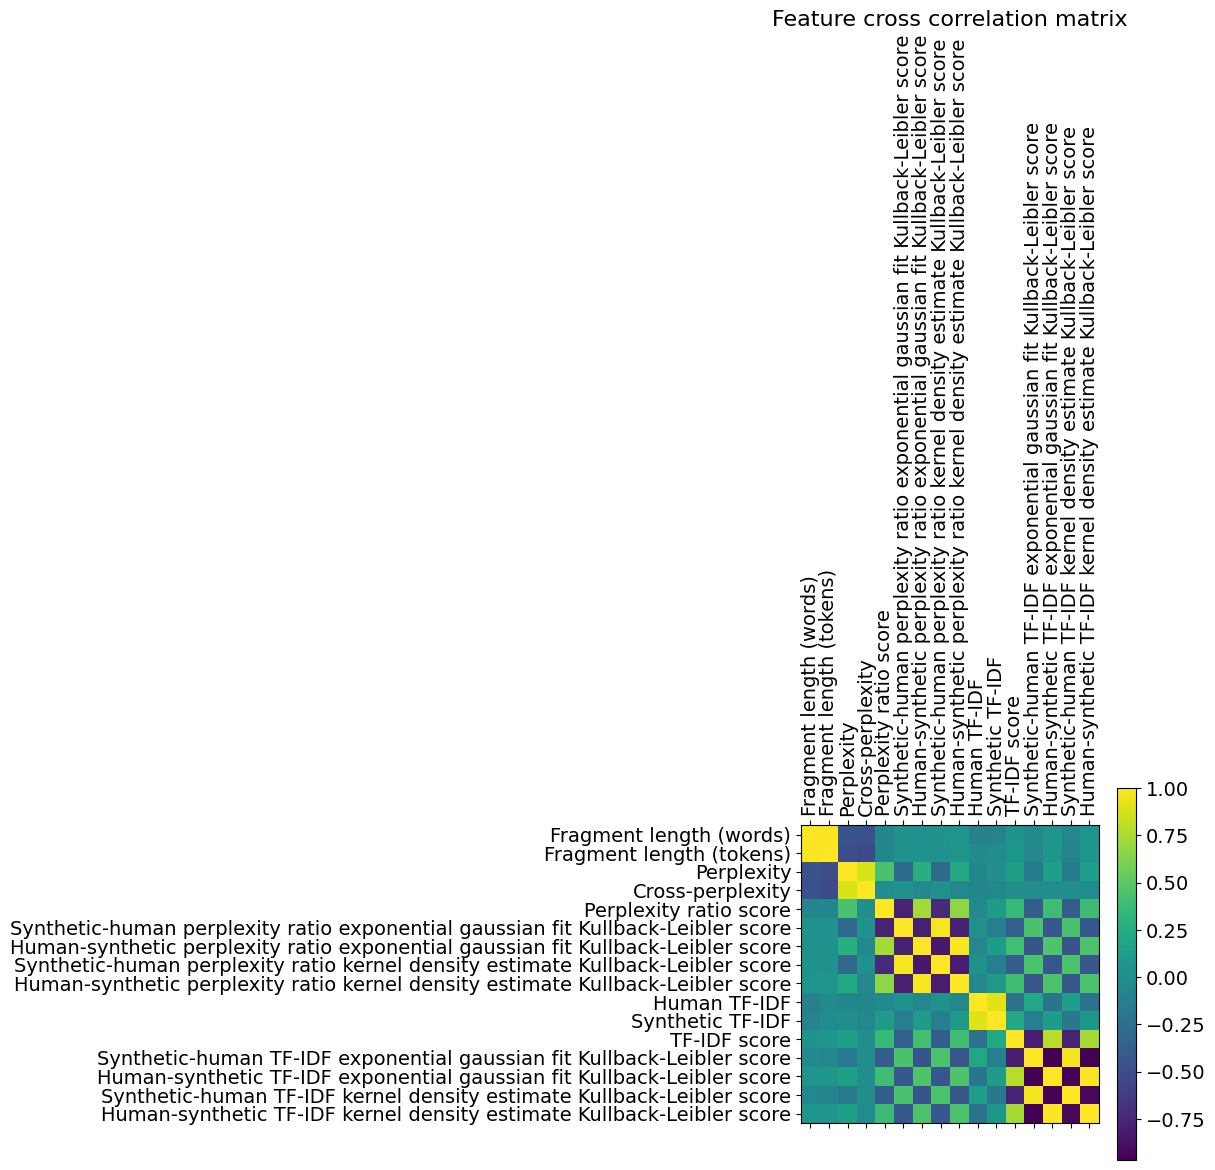

In [6]:
plt.matshow(features_train_df.corr())
plt.xticks(range(features_train_df.select_dtypes(['number']).shape[1]), features_train_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(features_train_df.select_dtypes(['number']).shape[1]), features_train_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)
plt.title('Feature cross correlation matrix', fontsize=16)
plt.show()

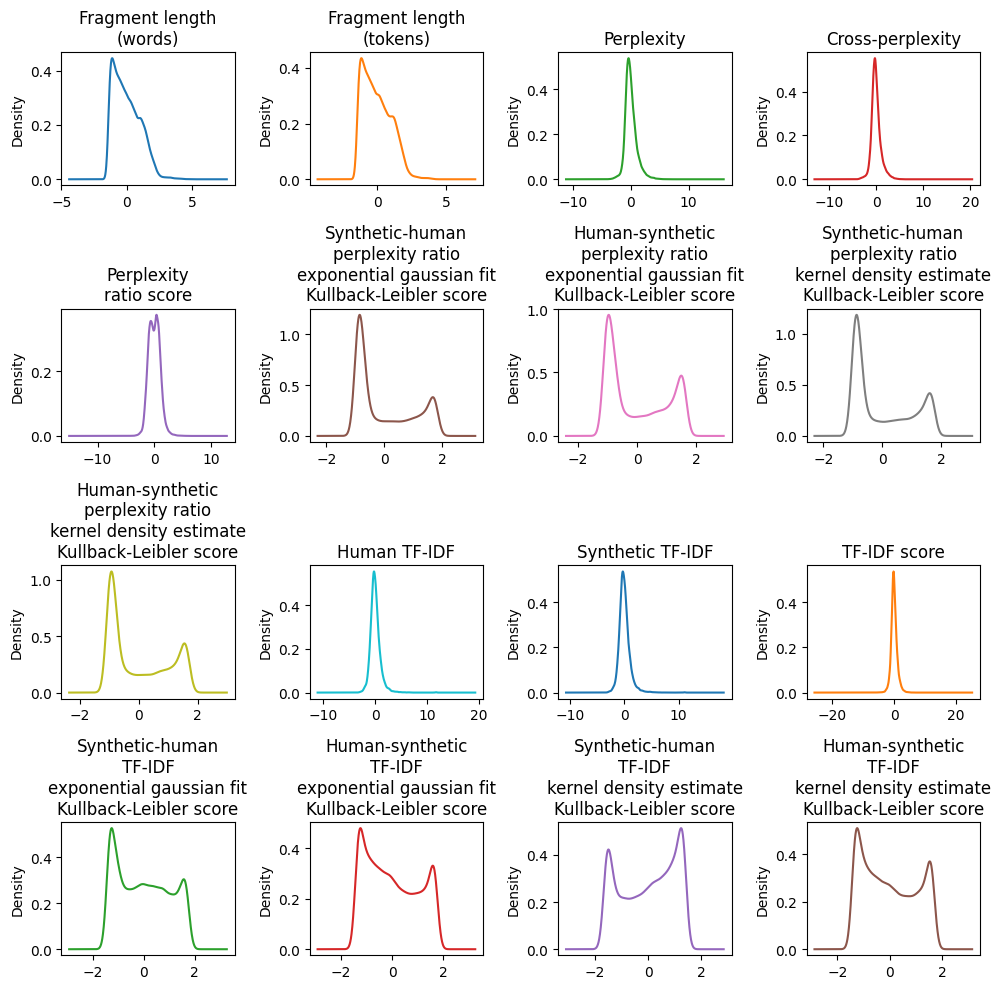

In [7]:
plot_titles = list(training_data_df.drop(['Source'], axis = 1).columns)
plot_titles = ['Synthetic-human\nperplexity ratio\nexponential gaussian fit\nKullback-Leibler score' if x=='Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Human-synthetic\nperplexity ratio\nexponential gaussian fit\nKullback-Leibler score' if x=='Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Synthetic-human\nperplexity ratio\nkernel density estimate\nKullback-Leibler score' if x=='Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Human-synthetic\nperplexity ratio\nkernel density estimate\nKullback-Leibler score' if x=='Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score' else x for x in plot_titles]

plot_titles = ['Synthetic-human\nTF-IDF\nexponential gaussian fit\nKullback-Leibler score' if x=='Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Human-synthetic\nTF-IDF\nexponential gaussian fit\nKullback-Leibler score' if x=='Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Synthetic-human\nTF-IDF\nkernel density estimate\nKullback-Leibler score' if x=='Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Human-synthetic\nTF-IDF\nkernel density estimate\nKullback-Leibler score' if x=='Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score' else x for x in plot_titles]

plot_titles = ['Perplexity\nratio score' if x=='Perplexity ratio score' else x for x in plot_titles]
plot_titles = ['Fragment length\n(words)' if x=='Fragment length (words)' else x for x in plot_titles]
plot_titles = ['Fragment length\n(tokens)' if x=='Fragment length (tokens)' else x for x in plot_titles]

n_cols = len(features_train_df.columns) // 4
n_rows = (len(features_train_df.columns) // 4) + (len(features_train_df.columns) % 4)

features_train_df.plot(title = plot_titles, kind = 'density', subplots = True, sharex = False, legend = False, layout = (n_rows,n_cols), figsize = (10,10))

plt.tight_layout()
plt.show()

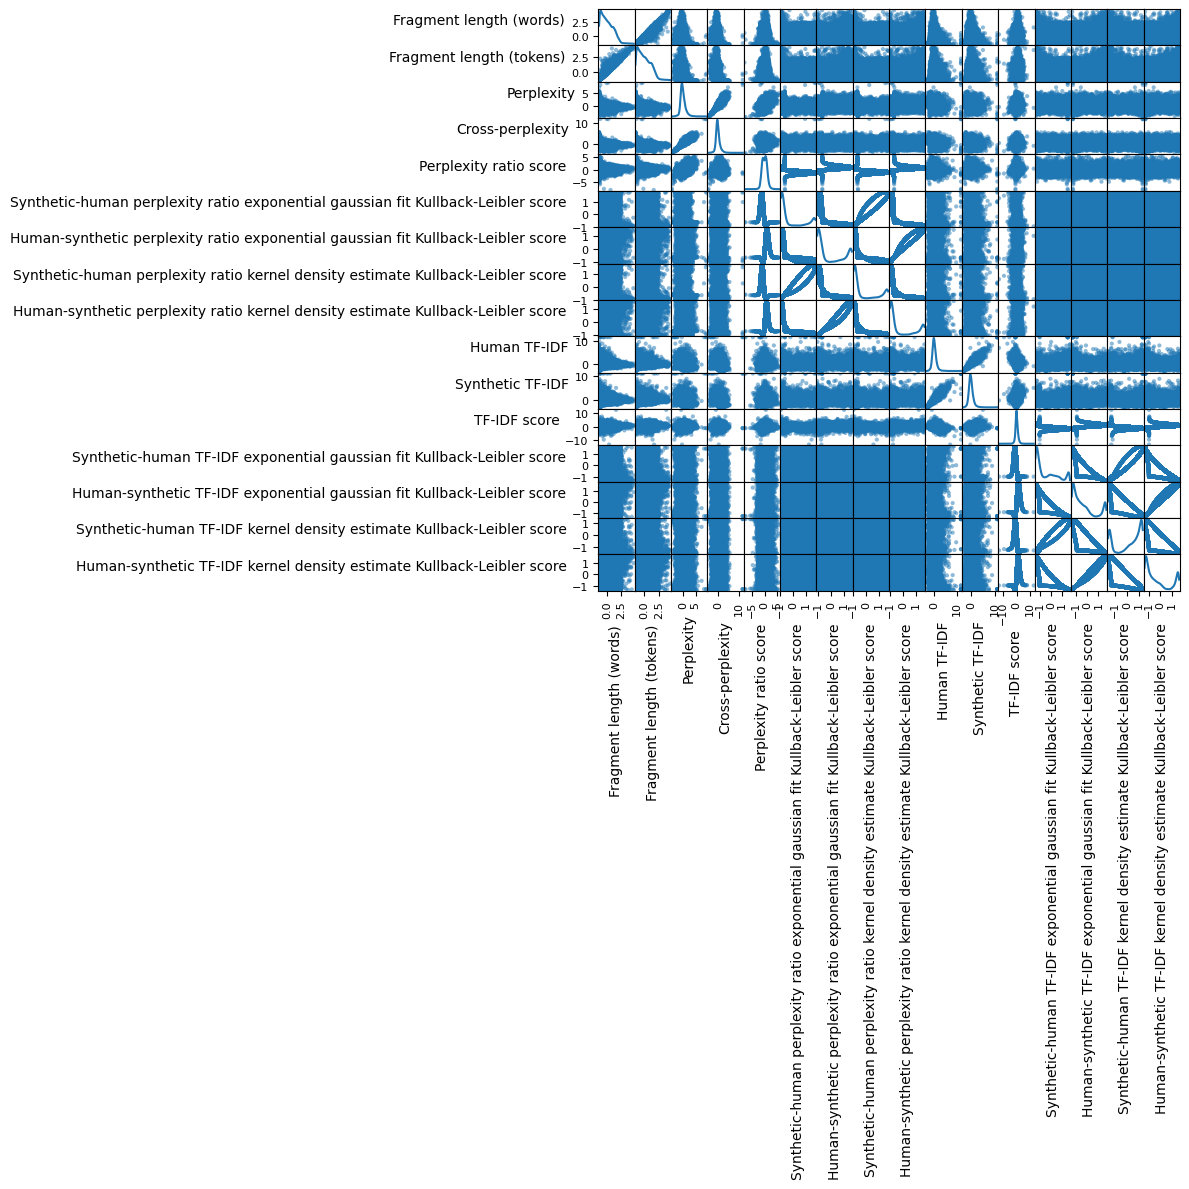

In [8]:
axes = scatter_matrix(features_train_df, figsize=(12,12), diagonal='kde')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

## 2. Univariate feature selection

In [9]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

### 2.1. Mutual information

In [10]:
results = mutual_info_classif(features_train_df, labels_train)

univariate_mi_results = {}

for feature, result in zip(feature_column_names, results):
    univariate_mi_results[feature] = result

univariate_mi_results = dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

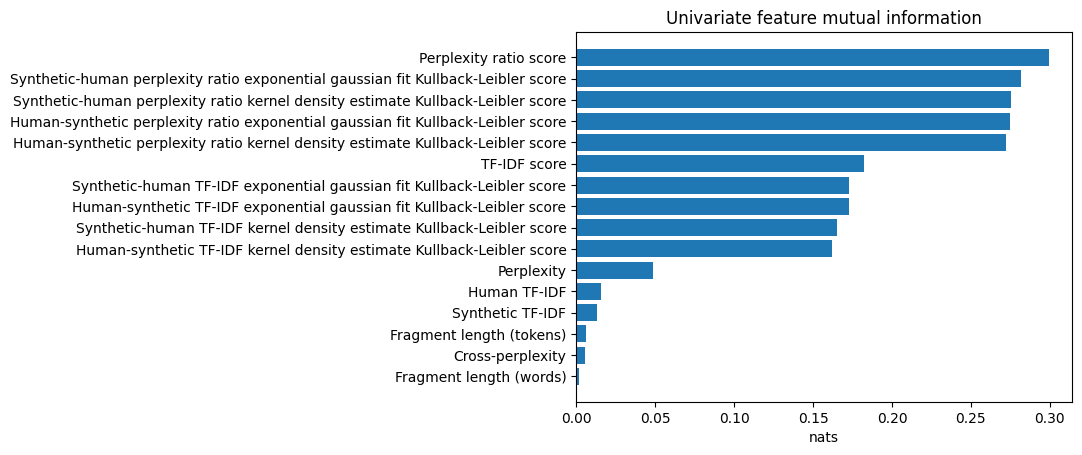

In [11]:
plt.title('Univariate feature mutual information')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label=list(univariate_mi_results.keys())
)

plt.xlabel('nats')

plt.show()

### 2.2. F-Test

In [12]:
selector = SelectKBest(f_classif, k=4)
selector.fit(features_train_df, labels_train)

univariate_ftest_results = {}

for feature, result in zip(feature_column_names, selector.pvalues_):
    univariate_ftest_results[feature] = result

univariate_ftest_results = dict(reversed(sorted(univariate_ftest_results.items(), key=lambda item: item[1])))

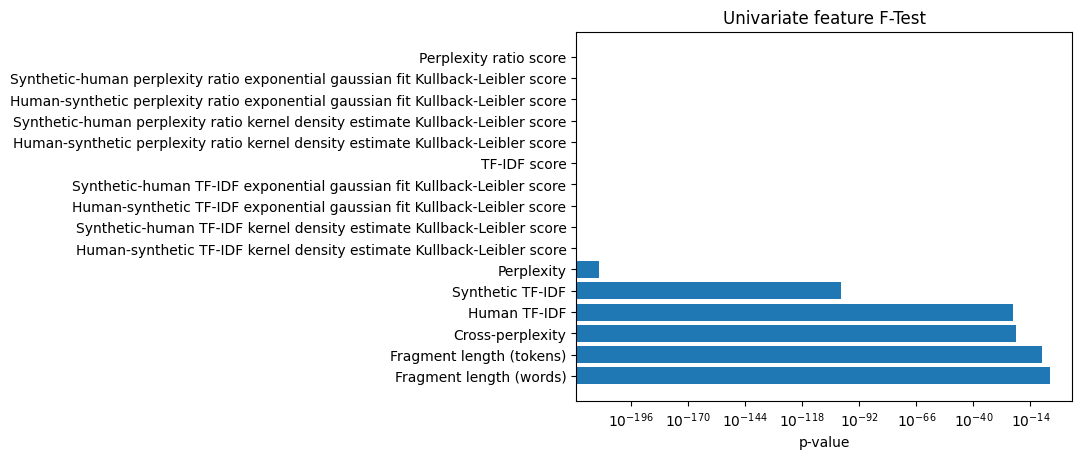

In [13]:
plt.title('Univariate feature F-Test')

plt.barh(
    np.arange(len(univariate_ftest_results.values())),
    univariate_ftest_results.values(),
   
    tick_label=list(univariate_ftest_results.keys())
)
plt.xscale('log')
plt.xlabel('p-value')

plt.show()

OK, cool - both methods seem to agree and many of our features are clearly significant. Question is now, do we need all of them? We already know we have some highly correlated/similar features that we could probably afford to loose.

## 3. Recursive feature elimination

In [18]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer
import functions.notebook_helper as helper_funcs

rfecv = RFECV(
    estimator = XGBClassifier(),
    cv = StratifiedShuffleSplit(5),
    scoring = make_scorer(helper_funcs.negated_binary_cross_entropy),
    min_features_to_select = 1,
    step = 1,
    n_jobs = 5
)

rfecv.fit(features_train_df, labels_train)

print(f'Optimal number of features: {rfecv.n_features_}')

cv_results = pd.DataFrame(rfecv.cv_results_)
cv_results.head(16)

Optimal number of features: 10


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,-6.140024,0.281298,-6.318142,-5.629195,-6.301338,-6.402159,-6.049284
1,-4.994020,0.166821,-5.242713,-4.755410,-4.889838,-5.091481,-4.990660
2,-4.994020,0.287218,-5.158695,-4.486553,-5.309927,-5.125088,-4.889838
3,-4.943610,0.287218,-5.225910,-4.452946,-5.158695,-5.091481,-4.789017
4,-4.893199,0.130766,-5.041070,-4.822624,-4.856231,-5.041070,-4.704999
5,-4.805820,0.398780,-5.108285,-4.100071,-5.007463,-5.175499,-4.637785
6,-4.792378,0.349966,-5.057874,-4.150481,-4.990660,-5.074678,-4.688195
7,-4.792378,0.272280,-4.873035,-4.251303,-4.957053,-4.957053,-4.923445
8,-4.752049,0.378644,-4.789017,-4.032856,-4.940249,-5.141892,-4.856231
9,-4.614260,0.208147,-4.570570,-4.234499,-4.704999,-4.839428,-4.721803


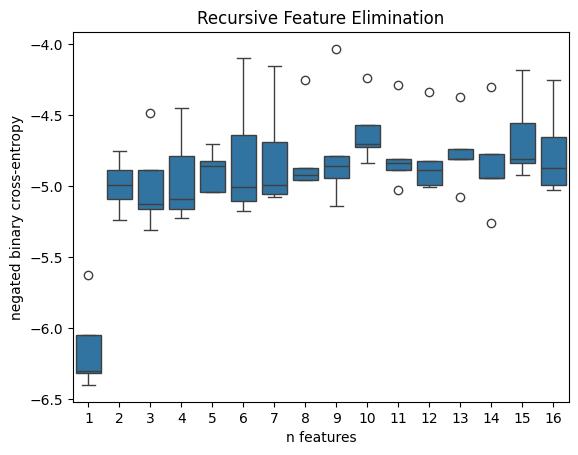

In [41]:
import seaborn as sns

long_cv_results = pd.melt(cv_results.drop(['mean_test_score', 'std_test_score'], axis = 1).reset_index(), id_vars='index')
long_cv_results.drop(['variable'], axis = 1, inplace = True)
long_cv_results.rename({'index': 'n features', 'value': 'negated binary cross-entropy'}, axis = 1, inplace = True)
long_cv_results['n features'] = long_cv_results['n features'] + 1

plt.title('Recursive Feature Elimination')
sns.boxplot(y = 'negated binary cross-entropy', x = 'n features', data = long_cv_results)
plt.show()